# 과제1 : 고객 세분화 및 RFM 분석
브라질 지역별 고객들의 구매 패턴을 분석하여 RFM(Recency, Frequency, Monetary) 모델을 구축하고, 고객을 세분화하여 각 세그먼트의 특성과 비즈니스 전략을 제시하세요.

In [2]:
# ============================================================
# 고객 세분화 & RFM 분석
# 1. 데이터 전처리
# 2. 지역별 구매 패턴 분석
# 3. RFM
# 4. 세그먼트 분류 및 전략 제시
# ============================================================

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from datetime import datetime, timedelta
import warnings
import matplotlib.ticker as mticker

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# csv
customers = pd.read_csv('./olist_customers_dataset.csv')      # 고객
orders = pd.read_csv('./olist_orders_dataset.csv')            # 주문
payments = pd.read_csv('./olist_order_payments_dataset.csv')  # 결제
reviews = pd.read_csv('./olist_order_reviews_dataset.csv')    # 리뷰
items     = pd.read_csv('./olist_order_items_dataset.csv')    # 주문상품

# 데이터 확인
customers.head(), customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


(                        customer_id                customer_unique_id  \
 0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
 1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
 2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
 3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
 4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
 
    customer_zip_code_prefix          customer_city customer_state  
 0                     14409                 franca             SP  
 1                      9790  sao bernardo do campo             SP  
 2                      1151              sao paulo             SP  
 3                      8775        mogi das cruzes             SP  
 4                     13056               campinas             SP  ,
 None)

In [ ]:
# 1) 데이터 전처리, 2) 지역별 구매 패턴 분석
# ---------------------------------------

# (1) 날짜형 변환
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for c in date_cols:
    if c in orders.columns:
        orders[c] = pd.to_datetime(orders[c], errors='coerce')

# (2) 구매일 결측 제거
orders = orders[~orders['order_purchase_timestamp'].isna()].copy()

# (3) 배송 SLA 평균 계산
valid = orders.dropna(subset=['order_delivered_customer_date']).copy()
valid['delivery_days'] = (valid['order_delivered_customer_date'] - valid['order_purchase_timestamp']).dt.days
avg_delivery_days = valid['delivery_days'].mean() if not valid.empty else 10.0
if not np.isfinite(avg_delivery_days) or avg_delivery_days < 0:
    avg_delivery_days = 10.0

# (4) 상태 필터링 및 배송일 보정
orders['order_status'] = orders['order_status'].astype(str).str.lower()
orders = orders[orders['order_status'].isin(['delivered','shipped'])]

# 배송중인데 배송일 있으면 배송완료로
mask_shipped = (orders['order_status']=='shipped') & (~orders['order_delivered_customer_date'].isna())
orders.loc[mask_shipped,'order_status'] = 'delivered'

# 배송완료인데 배송일 없음 → 구매일 + SLA 평균
mask_missing = (orders['order_status']=='delivered') & (orders['order_delivered_customer_date'].isna())
orders.loc[mask_missing,'order_delivered_customer_date'] = (
    orders.loc[mask_missing,'order_purchase_timestamp'] + pd.to_timedelta(avg_delivery_days, unit='D')
)

# (5) 결제금액 합산
pay_sum = payments.groupby('order_id')['payment_value'].sum().reset_index()
orders_df = pd.merge(orders, pay_sum, on='order_id', how='left')
orders_df['payment_value'] = orders_df['payment_value'].fillna(0.0)

# (6) 이상치 처리: 결제금액 0 제거 + 상위 1% 컷
orders_df = orders_df[orders_df['payment_value'] > 0].copy()
q99 = orders_df['payment_value'].quantile(0.99)
orders_df = orders_df[orders_df['payment_value'] <= q99].copy()

In [5]:
# 기본 통계값 계산
basic_stats = customers.describe(include='all')

# 고유 고객 수 계산
unique_customers_count = customers['customer_unique_id'].nunique()

# 고객별 주문 횟수 계산
customer_order_counts = customers['customer_unique_id'].value_counts()

# 결과 출력
basic_stats, unique_customers_count, customer_order_counts.head()

(                             customer_id                customer_unique_id  \
 count                              99441                             99441   
 unique                             99441                             96096   
 top     06b8999e2fba1a1fbc88172c00ba8bc7  8d50f5eadf50201ccdcedfb9e2ac8455   
 freq                                   1                                17   
 mean                                 NaN                               NaN   
 std                                  NaN                               NaN   
 min                                  NaN                               NaN   
 25%                                  NaN                               NaN   
 50%                                  NaN                               NaN   
 75%                                  NaN                               NaN   
 max                                  NaN                               NaN   
 
         customer_zip_code_prefix customer_city cu

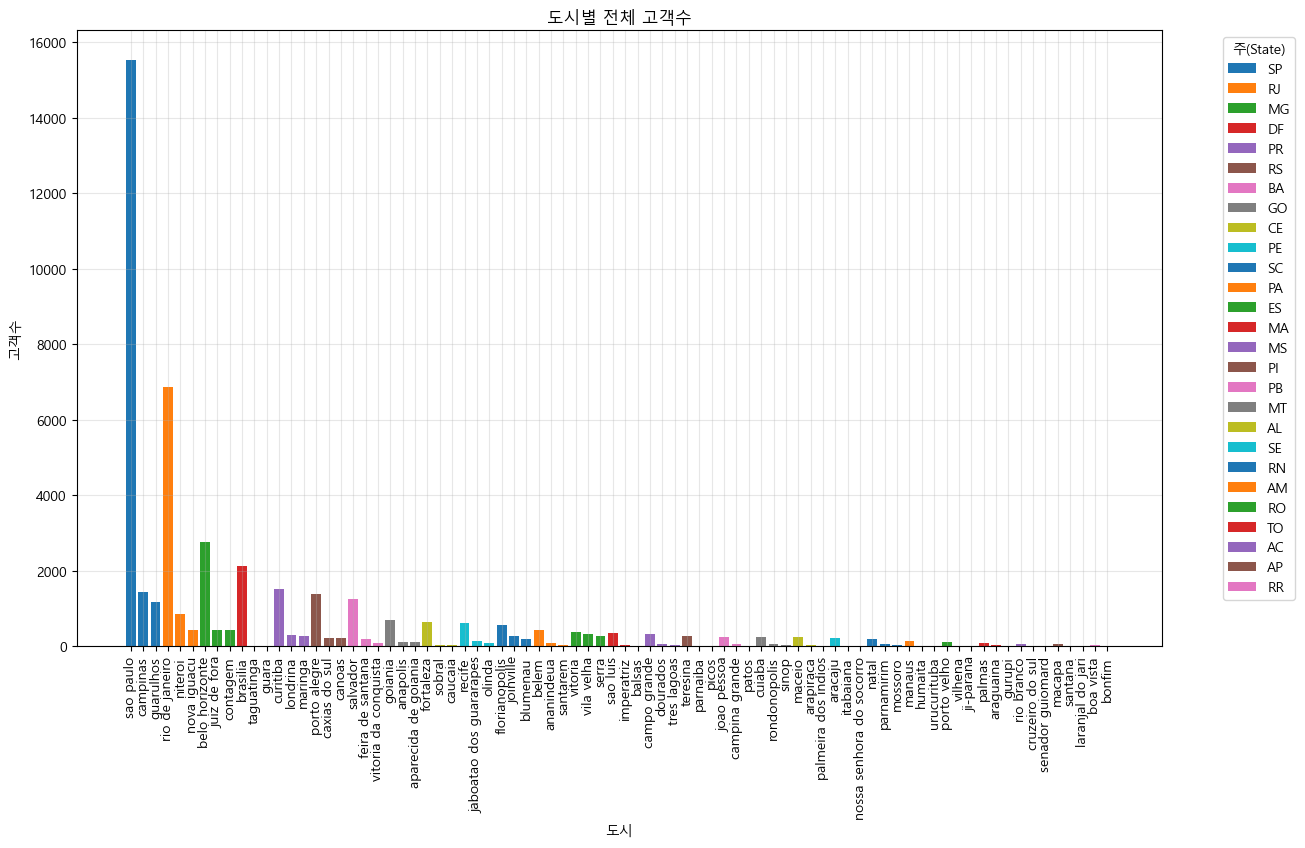

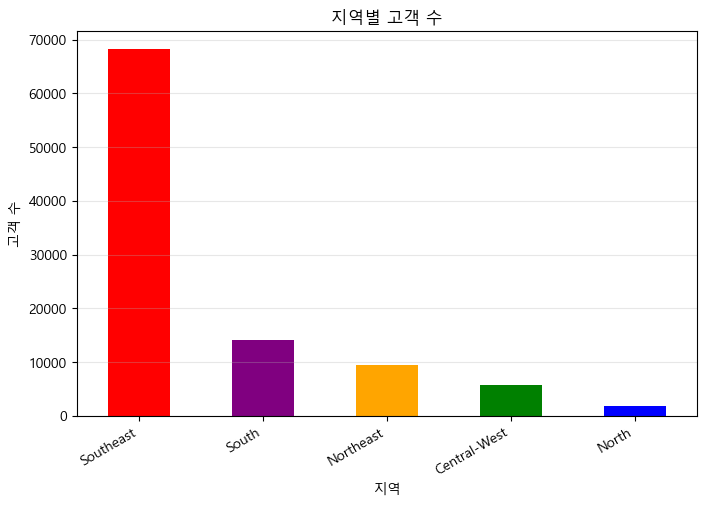

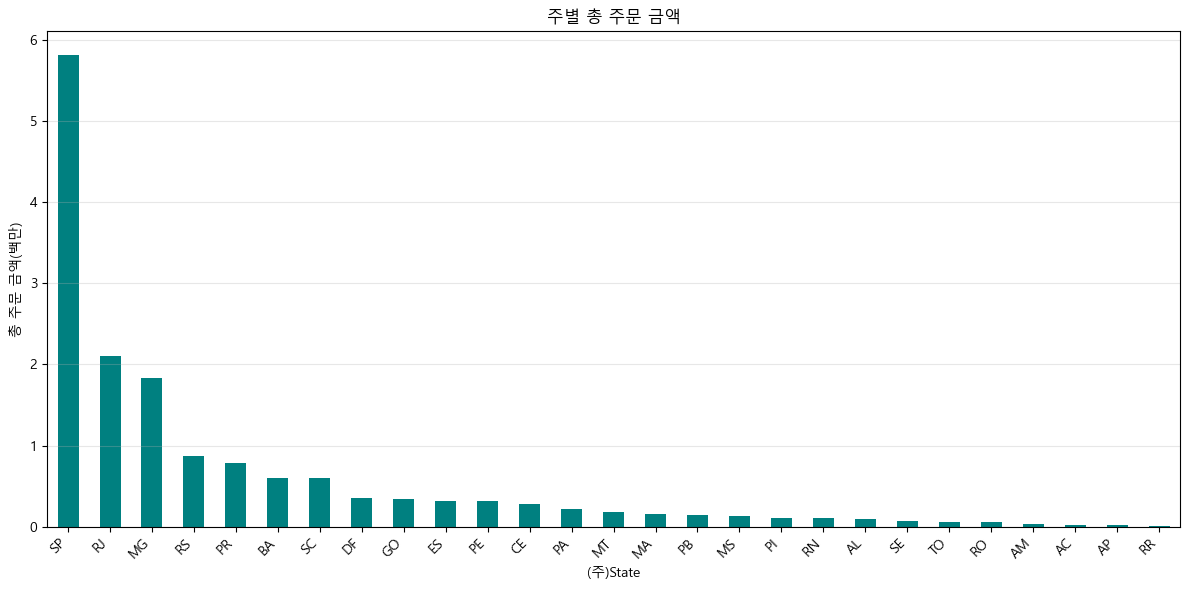

In [6]:
# 도시별 전체 고객 수 확인
top_cities_per_state = customers.groupby(['customer_state', 'customer_city']).size().reset_index(name='customer_count')
top_cities_per_state = top_cities_per_state.sort_values(['customer_state', 'customer_count'], ascending=[True, False])
top_cities_per_state_per_state = top_cities_per_state.groupby('customer_state').head(3).reset_index(drop=True)

top_cities_per_state_per_state = top_cities_per_state_per_state.sort_values('customer_count', ascending=False)

# 시각화
plt.figure(figsize=(14, 8))
for state in top_cities_per_state_per_state['customer_state'].unique():
    subset = top_cities_per_state_per_state[top_cities_per_state_per_state['customer_state'] == state]
    plt.bar(subset['customer_city'], subset['customer_count'], label=state)

plt.title('도시별 전체 고객수')
plt.xlabel('도시')
plt.ylabel('고객수')
plt.xticks(rotation=90)
plt.legend(title='주(State)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# 지역별 고객 수
uf_to_region = {
    # North
    "AC":"North","AP":"North","AM":"North","PA":"North","RO":"North","RR":"North","TO":"North",
    # Northeast
    "AL":"Northeast","BA":"Northeast","CE":"Northeast","MA":"Northeast","PB":"Northeast",
    "PE":"Northeast","PI":"Northeast","RN":"Northeast","SE":"Northeast",
    # Central-West
    "DF":"Central-West","GO":"Central-West","MT":"Central-West","MS":"Central-West",
    # Southeast
    "ES":"Southeast","MG":"Southeast","RJ":"Southeast","SP":"Southeast",
    # South
    "PR":"South","RS":"South","SC":"South"
}

customers['region'] = customers['customer_state'].map(uf_to_region)
customer_regions = customers['region'].value_counts().sort_values(ascending=False)

# 고정 색상 팔레트(지역별)✅
REGION_COLORS = {
    'North':        'blue',
    'Northeast':    'orange',
    'Central-West': 'green',
    'Southeast':    'red',
    'South':        'purple',
    None:           'gray'
}

# 지역 순서에 맞춰 색상 리스트 생성
colors = [REGION_COLORS[r] for r in customer_regions.index]

plt.figure(figsize=(8, 5))
customer_regions.plot(kind='bar', color=colors)
plt.title('지역별 고객 수')
plt.xlabel('지역')
plt.ylabel('고객 수')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()



# 주별 주문 금액

# 주문 아이템 금액 (상품가격 + 배송비)
items['order_amount'] = items['price'] + items['freight_value']

# 주문-고객 결합 → state 정보 붙이기
orders_with_state = orders.merge(
    customers[['customer_id','customer_state']], on='customer_id', how='left'
)

# 주문 아이템과 주문 결합
items_with_state = items.merge(
    orders_with_state[['order_id','customer_state']], on='order_id', how='left'
)

# 주별 총 주문금액
state_sales = (items_with_state.groupby('customer_state')['order_amount']
               .sum()
               .sort_values(ascending=False))

# 시각화
plt.figure(figsize=(12,6))
ax = state_sales.plot(kind='bar', color='teal')
state_sales.plot(kind='bar', color='teal')
plt.title('주별 총 주문 금액')
plt.xlabel('(주)State')
plt.ylabel('총 주문 금액(백만)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, p: f'{int(x/1e6):,}')
)
plt.tight_layout()
plt.show()


RFM 분석
- R(Recency, 얼마나 최근)
- F(Frequency, 얼마나 자주)
- M(Monetary, 얼마나 많이)

단계

1. 데이터 확인
2. 각 주문의 총 금액을 계산
3. 각 고객의 최근 구매 날짜(Recency), 구매 빈도(Frequency), 총 구매 금액(Monetary)을 계산
4. 각 지표를 5점 척도로 스코어링

1. 데이터 확인

In [ ]:
customers.head(), orders.head(), payments.head(), reviews.head()

(                        customer_id                customer_unique_id  \
 0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
 1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
 2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
 3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
 4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
 
    customer_zip_code_prefix          customer_city customer_state     region  
 0                     14409                 franca             SP  Southeast  
 1                      9790  sao bernardo do campo             SP  Southeast  
 2                      1151              sao paulo             SP  Southeast  
 3                      8775        mogi das cruzes             SP  Southeast  
 4                     13056               campinas             SP  Southeast  ,
                            order_id                       customer_id  \

In [8]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [9]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


2. 각 주문의 총 금액을 계산

In [10]:
# 주문별 총 결제금액
order_payment_total = payments.groupby('order_id')['payment_value'].sum().reset_index()

# 합치기
orders_df = pd.merge(orders, order_payment_total, on='order_id')

# 데이터 확인
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,28.62


3. 각 고객의 RFM 값 계산

In [ ]:
# 3) RFM
# ------

# 주문 데이터와 고객 데이터를 병합하여 각 주문에 대한 customer_id 확보
orders_customers_df = pd.merge(orders_df, customers, on='customer_id')

# 기준 날짜 설정
now = datetime(2018, 12, 31)

# 고객별 Recency, Frequency, Monetary 계산
rfm_df = orders_customers_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (now - pd.to_datetime(x).max()).days,  # 기준 날짜와의 차이(최신 구매일 기준)
    'order_id': pd.Series.nunique,  # 중복 집계 방지
    'payment_value': 'sum'                
}).reset_index()

# 컬럼명 가독성 있게 변경
rfm_df.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

# 데이터 확인
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,234,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,237,1,27.19
2,0000f46a3911fa3c0805444483337064,660,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,444,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,411,1,196.89


4. 각 지표를 5점 척도로 스코어링

In [ ]:
rfm_df['R_score'] = pd.qcut(rfm_df['Recency'].rank(method='first'), 5, labels=[5,4,3,2,1]).astype(int)
# 낮을수록 최근 > 높은 점수
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

rfm_df['RFM_score'] = rfm_df[['R_score','F_score','M_score']].sum(axis=1)

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,234,1,141.90,4,1,4,9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,237,1,27.19,4,1,1,6
2,0000f46a3911fa3c0805444483337064,660,1,86.22,1,1,2,4
3,0000f6ccb0745a6a4b88665a16c9f078,444,1,43.62,2,1,1,4
4,0004aac84e0df4da2b147fca70cf8255,411,1,196.89,2,1,4,7


### 세분화, 특징 및 전략

In [13]:
def segment5(row):
    R, F, M = int(row['R_score']), int(row['F_score']), int(row['M_score'])
    if R >= 4 and F >= 4 and M >= 4:
        return "VIP"
    if R >= 4 and F <= 2 and M <= 2:
        return "New Customers"
    if R >= 4 and (F >= 3 or M >= 3):
        return "Loyal"
    if R >= 3 and (F >= 2 or M >= 2):
        return "Potential"
    return "At Risk"

rfm_df['segment'] = rfm_df.apply(segment5, axis=1)

,segment,n_customers,recency_avg,freq_avg,monetary_avg,share(%)
0,At Risk,38557,513.90,1.03,162.67,40.85
1,Loyal,25281,212.94,1.01,159.53,26.78
2,Potential,18082,342.54,1.04,161.80,19.16
3,VIP,6540,213.44,1.18,312.38,6.93
4,New Customers,5938,213.48,1.00,54.90,6.29


segment,VIP,Loyal,Potential,At Risk,New Customers
region,,,,,
Central-West,7.50,26.10,20.90,40.00,5.50
North,8.60,21.80,19.20,46.90,3.50
Northeast,7.80,25.60,19.20,43.50,3.90
South,7.20,25.20,19.60,42.60,5.40
Southeast,6.70,27.50,18.90,40.00,6.90


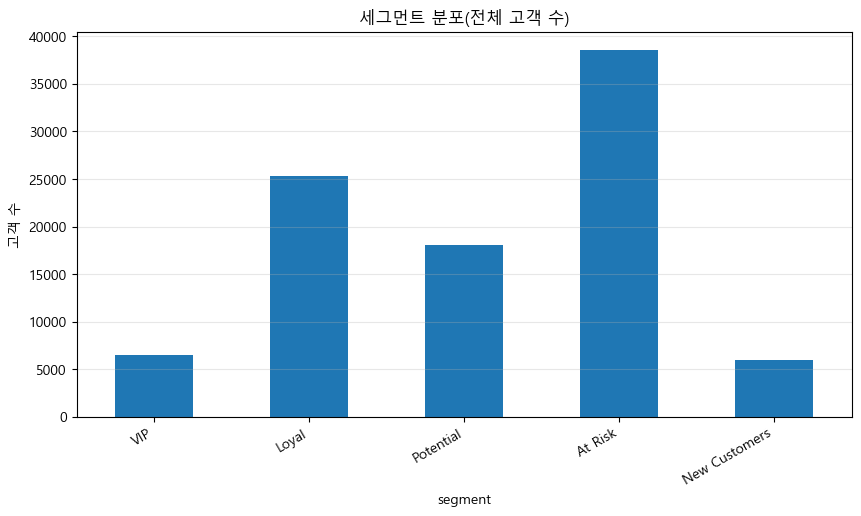

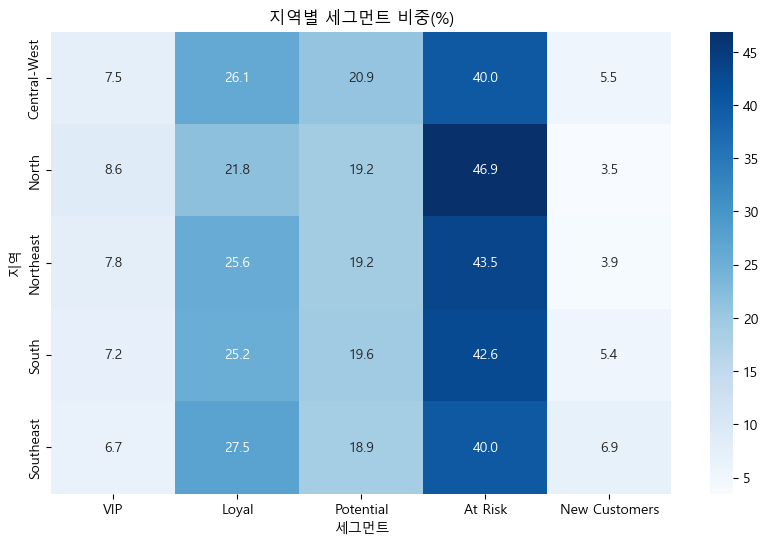

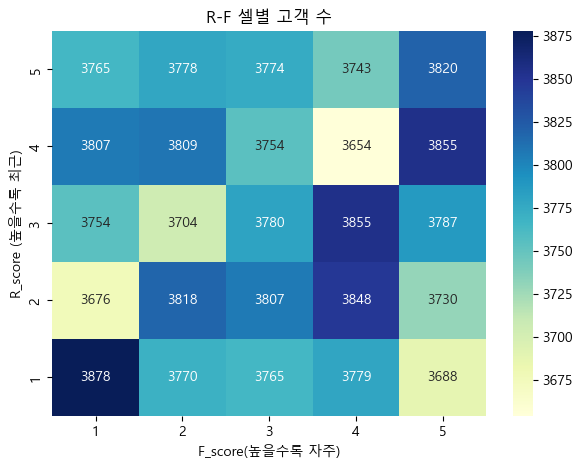

원본 데이터 개수: 94398, 필터링 후: 94380
최대 구매 금액 (원화 환산): 3,979,550 원


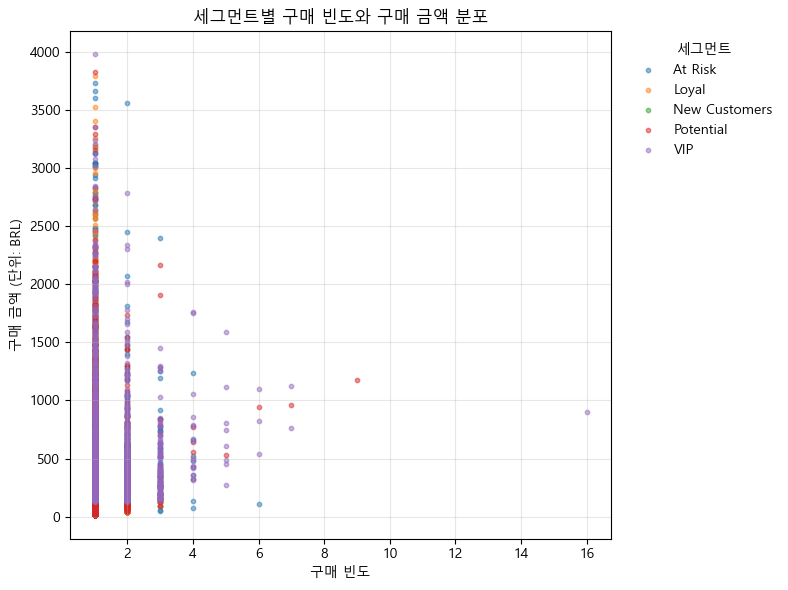

,특징,전략(요약)
segment,,
VIP,가장 최근·자주·고액으로 구매하는 핵심 매출 우수 고객,"프리미엄 멤버십, 사전 구매 기회, 한정판 리워드 제공 / 고가 상품 묶음 판매, ..."
Loyal,"구매 빈도와 금액이 모두 높고, 최근에도 꾸준히 활동하는 충성 고객",적립금/정기배송 서비스로 고객 생애가치(한 고객이 평생 쓰는 총 금액) 늘리기 / ...
Potential,최근에 유입되어 반복 구매를 시작한 잠재 고객,초기 주문건에 누적 혜택을 주는 계단식 쿠폰 / 개인별 맞춤 추천으로 특정 카테고리...
At Risk,과거엔 우수했지만 최근 구매가 끊긴 위험 고객,강한 인센티브(쿠폰/리워드)나 무료 교환반품 혜택 제공 / 최근 본 상품·관심 상품...
New Customers,"최근 첫 구매를 한 신규 고객, F/M 낮음","브랜드 소개, 반품/배송 안내 등 온보딩 메시지 제공 / 재구매 유도 쿠폰과 베스트..."


In [ ]:
# 고객 지역 매핑

uf_to_region = {
    # North
    "AC":"North","AP":"North","AM":"North","PA":"North","RO":"North","RR":"North","TO":"North",
    # Northeast
    "AL":"Northeast","BA":"Northeast","CE":"Northeast","MA":"Northeast","PB":"Northeast",
    "PE":"Northeast","PI":"Northeast","RN":"Northeast","SE":"Northeast",
    # Central-West
    "DF":"Central-West","GO":"Central-West","MT":"Central-West","MS":"Central-West",
    # Southeast
    "ES":"Southeast","MG":"Southeast","RJ":"Southeast","SP":"Southeast",
    # South
    "PR":"South","RS":"South","SC":"South"
}

# customer_unique_id 기준 대표 주/권역 추출(동일 unique_id 다수 행 있을 수 있어 mode 사용)
cust_state_mode = (
    customers
      .groupby('customer_unique_id')['customer_state']
      .agg(lambda s: s.value_counts().index[0])
      .to_frame()
      .reset_index()
)
cust_state_mode['region'] = cust_state_mode['customer_state'].map(uf_to_region)

rfm_geo = rfm_df.merge(cust_state_mode, on='customer_unique_id', how='left')

# 세그먼트
pd.options.display.float_format = lambda x: f"{x:,.2f}"

seg_order = ["VIP","Loyal","Potential","At Risk","New Customers"]


# 세그먼트 프로파일 요약표
seg_profile = (
    rfm_geo
      .groupby('segment')
      .agg(
          n_customers = ('customer_unique_id','nunique'),
          recency_avg = ('Recency','mean'),
          freq_avg    = ('Frequency','mean'),
          monetary_avg= ('Monetary','mean')
      )
      .sort_values('n_customers', ascending=False)
      .reset_index()
)
seg_profile['share(%)'] = (seg_profile['n_customers'] / seg_profile['n_customers'].sum() * 100).round(2)
display(seg_profile)

# 지역별 세그먼트 분포(비중)
region_seg = (
    rfm_geo
      .dropna(subset=['region'])
      .groupby(['region','segment'])['customer_unique_id']
      .nunique()
      .reset_index(name='n')
)
region_tot = region_seg.groupby('region')['n'].sum().rename('region_total')
region_seg = region_seg.merge(region_tot, on='region')
region_seg['share'] = region_seg['n'] / region_seg['region_total']

pivot_region_seg = (
    region_seg
      .pivot(index='region', columns='segment', values='share')
      .fillna(0.0)
      .reindex(columns=seg_order)
)
display((pivot_region_seg*100).round(1))

# 시각화 
plt.figure(figsize=(10,5))
counts = rfm_geo['segment'].value_counts().reindex(seg_order)
counts.plot(kind='bar')
plt.title('세그먼트 분포(전체 고객 수)')
plt.ylabel('고객 수')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap((pivot_region_seg*100).round(1), annot=True, fmt=".1f", cmap='Blues')
plt.title('지역별 세그먼트 비중(%)')
plt.ylabel('지역'); plt.xlabel('세그먼트')
plt.show()

# R-F 그리드에서 고객수 히트맵(유의미한 시각화인가에 대해서 고민 필요)
rfm_rf = (
    rfm_geo
      .groupby(['R_score','F_score'])['customer_unique_id']
      .nunique()
      .reset_index(name='n')
      .pivot(index='R_score', columns='F_score', values='n')
      .sort_index(ascending=False)
)
plt.figure(figsize=(7,5))
sns.heatmap(rfm_rf, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('R-F 셀별 고객 수')
plt.xlabel('F_score(높을수록 자주)'); plt.ylabel('R_score (높을수록 최근)')
plt.show()

# 산점도
BRL_to_KRW = 1000  

# 4000 BRL 이하 데이터만 보존
df_filtered = rfm_geo[rfm_geo['Monetary'] <= 4000].copy()

# BRL → 원 환산
df_filtered['Monetary_KRW'] = df_filtered['Monetary'] * BRL_to_KRW

print(f"원본 데이터 개수: {len(rfm_geo)}, 필터링 후: {len(df_filtered)}")
print(f"최대 구매 금액 (원화 환산): {df_filtered['Monetary_KRW'].max():,.0f} 원")

# 산점도
df_filtered = rfm_geo[rfm_geo['Monetary'] <= 4000].copy()

plt.figure(figsize=(8,6))
for seg in sorted(df_filtered['segment'].dropna().unique()):
    subset = df_filtered[df_filtered['segment'] == seg]
    plt.scatter(subset['Frequency'], subset['Monetary'], s=10, alpha=0.5, label=seg)

plt.title('세그먼트별 구매 빈도와 구매 금액 분포')
plt.xlabel('구매 빈도')
plt.ylabel('구매 금액 (단위: BRL)')
plt.legend(title='세그먼트', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) 세그먼트 분류 및 전략 제시
# ---------------------------

#세그먼트별 특성과 비즈니스 전략(요약 테이블)
strategy5 = {
    'VIP': {
        '특징': '가장 최근·자주·고액으로 구매하는 핵심 매출 우수 고객',
        '전략': [
            '프리미엄 멤버십, 사전 구매 기회, 한정판 리워드 제공',
            '고가 상품 묶음 판매, 전담 상담 서비스 제공',
            '추천인 보상(지인 소개 시 혜택)제도 활성화'
        ]
    },
    'Loyal': {
        '특징': '구매 빈도와 금액이 모두 높고, 최근에도 꾸준히 활동하는 충성 고객',
        '전략': [
            '적립금/정기배송 서비스로 고객 생애가치(한 고객이 평생 쓰는 총 금액) 늘리기',
            '연관 카테고리 할인 쿠폰으로 다른 상품군 구매 유도',
            '관심 상품/브랜드 알림, 주기적인 재구매 유도'
        ]
    },
    'Potential': {
        '특징': '최근에 유입되어 반복 구매를 시작한 잠재 고객',
        '전략': [
            '초기 주문건에 누적 혜택을 주는 계단식 쿠폰',
            '개인별 맞춤 추천으로 특정 카테고리 구매 습관 제공',
            '정기구독을 유도하기 위한 체험용 샘플 제공'
        ]
    },
    'At Risk': {
        '특징': '과거엔 우수했지만 최근 구매가 끊긴 위험 고객',
        '전략': [
            '강한 인센티브(쿠폰/리워드)나 무료 교환반품 혜택 제공',
            '최근 본 상품·관심 상품 기반 맞춤 복귀 제안',
            'CS/배송 경험에 특이점이 없을지 점검 및 개선'
        ]
    },
    'New Customers': {
        '특징': '최근 첫 구매를 한 신규 고객, F/M 낮음',
        '전략': [
            '브랜드 소개, 반품/배송 안내 등 온보딩 메시지 제공',
            '재구매 유도 쿠폰과 베스트상품 추천',
            '리워드가 제공되는 리뷰 작성 요청으로 재구매 촉진'
        ]
    }
}

strategies_df = (
    pd.DataFrame([
        {'segment': seg, '특징': v['특징'], '전략(요약)': ' / '.join(v['전략'])}
        for seg, v in strategy5.items()
    ])
    .set_index('segment')
    .reindex(seg_order)
)
display(strategies_df)